# マインスイーパー

マインスイーパーは、数字で示された周囲のセルに爆弾（地雷）がいくつ存在するかをヒントに、安全なセルを見つけるパズルです。プレイヤーは、各セルに対して爆弾があるかどうかを推理しながらマスを開けていきます。数字は、開かれたセルの周りにある爆弾の数を示しています。空白のセルは爆弾がないことを意味します。

この問題をZ3のSATソルバーを使って解く方法について考えていきます。与えられたボードの中から爆弾がない、安全なセルを求めるプログラムを作成します。

In [21]:
from z3 import *

## 考える点

- マインスイーパーのルールに従い、各数字はその周囲にある地雷の数を示しており、すべての周囲のセルをチェックしなければならない。
- 解を求めるためには、各セルが地雷でない（爆弾でない）という制約をSATソルバーに与え、矛盾が発生しないかチェックする必要がある。
- そのためには、まず各セルの隣接セルを調べ、それぞれに対して制約条件を追加していく必要がある。

## 解法の概要

1. **隣接セルを取得する関数 (`get_neighbors`)**  
   各セルの周囲にある隣接セルをリストとして返す関数です。この関数は、与えられたセルの位置（x, y）とボードの幅と高さをもとに、セルの8方向（斜めを含む）を計算します。

2. **ボードの状態を解く関数 (`solve_board`)**  
   ボードを表す文字列から、各セルの情報を取り出して、隣接するセルの情報をZ3の制約に変換していきます。具体的には、数字で示されたセル周りにある隣接セルがすべて爆弾でないことを制約条件として追加します。

3. **安全なセルの特定 (`solver.push()`, `solver.add()`, `solver.pop()`)**  
   各セルが安全であるかどうかを確認するために、ソルバーの状態を変更し、矛盾（unsat）を検出して安全なセルを特定します。

## コード

次はマインスイーパーを解くプログラムです。`solve_board()` 関数は安全なセルのリストを返します。

In [ ]:
def get_neighbors(cell, h, w):
    cx, cy = cell
    directions = [
        (-1, -1), (-1, 0), (-1, 1),
        (0, -1),         (0, 1),
        (1, -1), (1, 0), (1, 1)
    ]

    neighbors = []

    for dy, dx in directions:
        nx, ny = cx + dx, cy + dy
        if 0 <= ny < h and 0 <= nx < w:
            neighbors.append((nx, ny))
    return neighbors

def solve_board(board_str):
    board = board_str.strip().split()
    h = len(board)
    w = len(board[0])
    cells = {}
    for y, row in enumerate(board):
        for x, v in enumerate(row):
            if v != '.':
                for nx, ny in get_neighbors((x, y), h, w):
                    if board[ny][nx] == '.':
                        cells[nx, ny] = Bool(f'{ny}-{nx}')
    
    solver = Solver()
    for y, row in enumerate(board):
        for x, v in enumerate(row):
            if v != '.':
                near_cells = [cells[loc] for loc in get_neighbors((x, y), h, w) if loc in cells]
                if near_cells:
                    solver.add(Sum(near_cells) == int(v))
    
    safe_positions = []            
    for cell in cells.values():
        solver.push()
        solver.add(cell == True)
        if solver.check() == unsat:
            safe_positions.append(str(cell))
        solver.pop()
    return safe_positions

def show_result(board_str, safe_positions):
    board = [list(row) for row in board_str.strip().split()]
    for cell in safe_positions:
        y, x = map(int, cell.split('-'))
        board[y][x] = '#'
    print("\n".join(" ".join(row) for row in board))

## 実行例

上の関数を使って、次のマインスイーパーの状態を解いてみます。

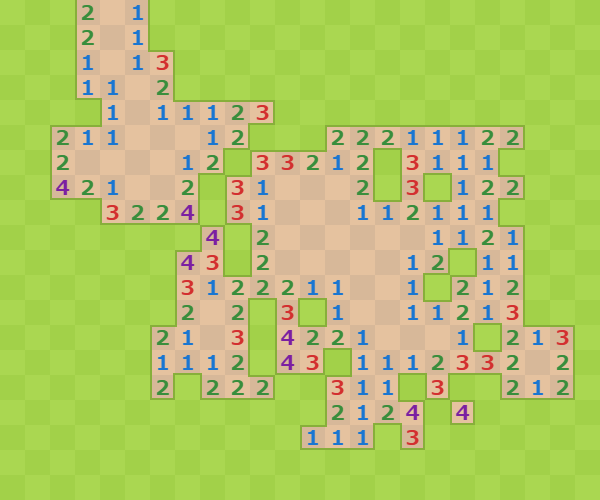

In [22]:
board_str = """
...201..................
...201..................
...1013.................
...1102.................
....1011123.............
..21100012...22211122...
..2000012.33212.3111....
..421002.310002.3.122...
....3224.31000112111....
........4.20000001121...
.......43.20000012.11...
.......3122211001.212...
.......202.3.10011213...
......2103.42210001.213.
......1112.43.111233202.
......2.222..311.3..212.
.............2124.4.....
............111.3.......
........................
........................
"""

safe_positions = solve_board(board_str)
print(safe_positions)
show_result(board_str, safe_positions)

['0-6', '2-2', '3-2', '1-7', '4-2', '3-8', '3-9', '3-11', '4-11', '4-1', '4-12', '4-13', '4-15', '4-16', '4-17', '4-19', '4-20', '6-21', '7-21', '8-21', '9-5', '9-21', '10-21', '13-5', '14-5', '12-22', '15-5', '16-7', '16-9', '16-10', '16-11', '16-19', '16-22', '17-18', '17-19', '17-11', '18-11', '18-12', '18-13', '18-14', '18-15', '18-16', '18-17']
. . . 2 0 1 # . . . . . . . . . . . . . . . . .
. . . 2 0 1 . # . . . . . . . . . . . . . . . .
. . # 1 0 1 3 . . . . . . . . . . . . . . . . .
. . # 1 1 0 2 . # # . # . . . . . . . . . . . .
. # # . 1 0 1 1 1 2 3 # # # . # # # . # # . . .
. . 2 1 1 0 0 0 1 2 . . . 2 2 2 1 1 1 2 2 . . .
. . 2 0 0 0 0 1 2 . 3 3 2 1 2 . 3 1 1 1 . # . .
. . 4 2 1 0 0 2 . 3 1 0 0 0 2 . 3 . 1 2 2 # . .
. . . . 3 2 2 4 . 3 1 0 0 0 1 1 2 1 1 1 . # . .
. . . . . # . . 4 . 2 0 0 0 0 0 0 1 1 2 1 # . .
. . . . . . . 4 3 . 2 0 0 0 0 0 1 2 . 1 1 # . .
. . . . . . . 3 1 2 2 2 1 1 0 0 1 . 2 1 2 . . .
. . . . . . . 2 0 2 . 3 . 1 0 0 1 1 2 1 3 . # .
. . . . . # 2 1 0 3 . 4 

## コードの詳細な説明

### 変数作成

`cells` 辞書は、マインスイーパーのボード上の各セルに対してブール変数を管理するために使用されます。辞書のキーはセルの座標 `(x, y)` であり、対応する値はそのセルが「安全であるかどうか」を示すブール変数です。この変数は Z3 の `Bool` 型で表され、後で問題の制約条件として使用されます。

以下のコード部分では、ボード上の数字セルの周辺の未開きセルに対してブール変数を作成して`cells`辞書に格納しています：

```python
cells = {}
for y, row in enumerate(board):
    for x, v in enumerate(row):
        if v != '.':
            for nx, ny in get_neighbors((x, y), h, w):
                if board[ny][nx] == '.':
                    cells[nx, ny] = Bool(f'{ny}-{nx}')
```

数字セルと隣接しないセルの状態が判定できないので、`cells` には格納しません。

### 制約条件の追加

制約条件の部分では、各数字セルに対してその周辺の未開きセルの総和がそのセルの値（数字）に等しいという条件を追加しています。これにより、数字セルが示す地雷の数を満たすように、未開きセルの状態（安全か地雷か）が決定されます。

以下のコード部分で制約が追加されています：

```python
for y, row in enumerate(board):
    for x, v in enumerate(row):
        if v != '.':  # 数字セルの場合
            near_cells = [cells[loc] for loc in get_neighbors((x, y), h, w) if loc in cells]
            if near_cells:
                solver.add(Sum(near_cells) == int(v))  # 周囲の未開きセルの総和がその数字セルの値に等しい
```

### 安全なセルを取得

制約条件を使って直接解を求めるのではなく、絶対に安全なセルを検出するために、`cells` の中の各セルに「水雷がある」という制約条件を一時的に追加して解いてみます。もし解が得られなかった場合、そのセルは安全なセルであると判断できます。こ追加時的な制約条件を削除するために、次のように処理します。

1. **一時的に水雷がある制約を追加**:
   - 各セルに対して「このセルに水雷がある」という仮定を追加します。これを一時的な制約として、`solver.push()` で解に追加します。

2. **制約の解決**:
   - `solver.check()` を使って、制約が満たされるかを確認します。もし `unsat` が返された場合、つまり矛盾が生じた場合、そのセルには水雷がない（安全なセル）と判断します。

3. **制約の削除**:
   - `solver.pop()` を使用して、一時的に追加した制約を削除します。このステップにより次のセルに対して新たな仮定を追加して検証することができます。

```python
safe_positions = []            
for cell in cells.values():
    solver.push()  # 一時的な制約を追加する前にsolverの状態を保存
    solver.add(cell == True)  # セルに水雷があると仮定
    if solver.check() == unsat:  # 矛盾が生じた場合、このセルは安全
        safe_positions.append(str(cell))
    solver.pop()  # 一時的な制約を削除
```

- **`solver.push()`**:
  - `push()` は Z3 の状態を保存し、新たな制約を追加できるようにします。これにより一時的に水雷があるという制約を追加しても、その後の制約を変更する前に元の状態に戻せるようになります。

- **`solver.add(cell == True)`**:
  - この行では、セル `cell` に水雷があると仮定します。`cell == True` は、このセルが地雷であるという制約を追加することになります。

- **`solver.check()`**:
  - `check()` は制約を満たす解が存在するかどうかを確認します。`unsat` は「矛盾が生じて解がない」という意味で返されるため、この場合はそのセルには地雷がない、安全なセルだと判断できます。

- **`solver.pop()`**:
  - `pop()` は `push()` で保存された Z3 の状態を元に戻します。この操作で一時的に追加した制約を削除し、次のセルに対して新しい仮定を試す準備をします。